
This notebook is dedicated to a machine learning project aimed at predicting target variables using various models. We start by loading and preprocessing the data, including imputation and encoding of categorical features. Subsequently, we utilize multiple models such as Logistic Regression, Random Forest, XGBoost, and Neural Networks to make predictions and evaluate their performance using metrics like accuracy, F1 score, and AUC score.

# Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import dill
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss, precision_score, recall_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from helper_functions import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

c:\Users\elige\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [ ]:
df_test = load_data('application_test.parquet')

In [3]:
df_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# Drop uneeded features

In [4]:
# assign the ID column to a variable for Late use in the final submission
id_test = df_test['SK_ID_CURR']

In [5]:
# drop uneeded features
df_test = drop_features(df_test, features_to_drop=['SK_ID_CURR'])

In [6]:
df_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# Impute Data

In [7]:
# impute to fill missing values
df_test = clean_data(df_test)

In [8]:
# check for missing values
df_test.isnull().sum().sum()

0

# Encode Data

In [9]:
# reset the index to avoid issues with the model
df_test = df_test.reset_index(drop=True)

In [10]:
# Get only categorical features:
categorical_cols = df_test.select_dtypes(include=['object']).columns.tolist()

# encode the categorical features to numerical values
df_test = encode_data(df_test, 'TARGET', categorical_cols, train=False,  model=TargetEncoder)


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


# Predictions

### Logistic Regression Model Predictions

In [11]:
# Load the trained model
with open('trained_logistic_model.pickle', 'rb') as f: 
    lr_model = dill.load(f)

# make predictions
y_new_pred_LR = predict_model(df_test, lr_model)
y_new_pred_LR

array([0.53648024, 0.54983641, 0.64888677, ..., 0.55094111, 0.43800931,
       0.54985438])

In [12]:
# Save predictions with corresponding IDs
model_LR = pd.DataFrame({'SK_ID_CURR': id_test, 'TARGET': y_new_pred_LR})
model_LR.to_csv('prediction_lr.csv', index=False)

### Random Forest Model Predictions

In [13]:
# Load the trained model
with open('trained_random_forest_model.pickle', 'rb') as f: 
    rf_model = dill.load(f)

# Load the test data
with open('splitted_train_test.pickle', 'rb') as f: 
    _, _, _, y_test = dill.load(f)

# reset the index to avoid issues with the model
y_test = y_test.reset_index(drop=True)

# make predictions
y_new_pred_RF = predict_model(df_test, rf_model)
y_new_pred_RF

array([0.44863725, 0.55327089, 0.38278735, ..., 0.4401126 , 0.43544796,
       0.5808102 ])

In [14]:
# Save predictions with corresponding IDs
model_RF = pd.DataFrame({'SK_ID_CURR': id_test, 'TARGET': y_new_pred_RF})
model_RF.to_csv('prediction_rf.csv', index=False)

### XGBoost Model Predictions

In [15]:
# Load the trained model
with open('trained_xgb_model.pickle', 'rb') as f: 
    xgb_model = dill.load(f)

# make predictions
y_new_pred_xgb = predict_model(df_test, xgb_model)
y_new_pred_xgb

array([0.38314664, 0.5360255 , 0.17660294, ..., 0.29796606, 0.41698918,
       0.6471115 ], dtype=float32)

In [16]:
# Save predictions with corresponding IDs
model_xgb = pd.DataFrame({'SK_ID_CURR': id_test, 'TARGET': y_new_pred_xgb})
model_xgb.to_csv('prediction_xgb.csv', index=False)

### Neural Network Model Predictions

In [17]:
# Load the trained model
with open('trained_nn_model.pickle', 'rb') as f:
    nn_model = dill.load(f)

# Load predict_model function
with open('predict_model.pickle', 'rb') as f:
    predict_model = dill.load(f)

# make predictions
y_new_pred_nn = predict_model(df_test, nn_model)
y_new_pred_nn.flatten()

1524/1524 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step


array([0.46243006, 0.46243006, 0.46243006, ..., 0.46243006, 0.46243006,
       0.46243006], dtype=float32)

In [18]:
# Save predictions with corresponding IDs
model_nn = pd.DataFrame({'SK_ID_CURR': id_test, 'TARGET': y_new_pred_nn.flatten()})
model_nn.to_csv('prediction_nn.csv', index=False)

# Metrics 

In [19]:
# Ensure y_test and y_new_pred are of the same length 
common_indices = y_test.index.intersection(df_test.index) 
y_test_aligned = y_test.loc[common_indices] 
y_new_pred_aligned = pd.Series(y_new_pred_LR, index=df_test.index).loc[common_indices]
y_new_pred_aligned1 = pd.Series(y_new_pred_RF, index=df_test.index).loc[common_indices]
y_new_pred_aligned2 = pd.Series(y_new_pred_xgb, index=df_test.index).loc[common_indices]
y_new_pred_aligned3 = pd.Series(y_new_pred_nn, index=df_test.index).loc[common_indices]


In [20]:

# Convert predicted probabilities to binary labels using a threshold (e.g., 0.5)
threshold = 0.5
y_new_pred_aligned_binary = (y_new_pred_aligned > threshold).astype(int)
y_new_pred_aligned1_binary = (y_new_pred_aligned1 > threshold).astype(int)
y_new_pred_aligned2_binary = (y_new_pred_aligned2 > threshold).astype(int)
y_new_pred_aligned3_binary = (y_new_pred_aligned3 > threshold).astype(int)

# Ensure the lengths are equal
if len(y_test_aligned) == len(y_new_pred_aligned_binary): 
    lr_accuracy = accuracy_score(y_test_aligned.values.flatten(), y_new_pred_aligned_binary) 
    lr_f1 = f1_score(y_test_aligned.values.flatten(), y_new_pred_aligned_binary)
    lr_auc = roc_auc_score(y_test_aligned.values.flatten(), y_new_pred_aligned_binary)

    # Similarly, calculate for other models
    rf_accuracy = accuracy_score(y_test_aligned.values.flatten(), y_new_pred_aligned1_binary)
    rf_f1 = f1_score(y_test_aligned.values.flatten(), y_new_pred_aligned1_binary)
    rf_auc = roc_auc_score(y_test_aligned.values.flatten(), y_new_pred_aligned1_binary)

    xgb_accuracy = accuracy_score(y_test_aligned.values.flatten(), y_new_pred_aligned2_binary)
    xgb_f1 = f1_score(y_test_aligned.values.flatten(), y_new_pred_aligned2_binary)
    xgb_auc = roc_auc_score(y_test_aligned.values.flatten(), y_new_pred_aligned2_binary)

    nn_accuracy = accuracy_score(y_test_aligned.values.flatten(), y_new_pred_aligned3_binary)
    nn_f1 = f1_score(y_test_aligned.values.flatten(), y_new_pred_aligned3_binary)
    nn_auc = roc_auc_score(y_test_aligned.values.flatten(), y_new_pred_aligned3_binary)
    
    print(f"LR: Accuracy Score: {lr_accuracy}, F1_score: {lr_f1}, AUC: {lr_auc}") 
    print(f"RF: Accuracy Score: {rf_accuracy}, F1_score: {rf_f1}, AUC: {rf_auc}") 
    print(f"xgb: Accuracy Score: {xgb_accuracy}, F1_score: {xgb_f1}, AUC: {xgb_auc}") 
    print(f"nn: Accuracy Score: {nn_accuracy}, F1_score: {nn_f1}, AUC: {nn_auc}") 

else: 
    print("Length mismatch: y_test_aligned has length", len(y_test_aligned), "while y_new_pred_aligned has length", len(y_new_pred_aligned))


LR: Accuracy Score: 0.5235926473001805, F1_score: 0.13992592592592595, AUC: 0.5050653533891105
RF: Accuracy Score: 0.6279542097488922, F1_score: 0.1283345349675559, AUC: 0.4971507260647733
xgb: Accuracy Score: 0.6277695716395865, F1_score: 0.129199462468804, AUC: 0.49833396603069063
nn: Accuracy Score: 0.9133636960446414, F1_score: 0.01767852989067225, AUC: 0.500954717813167


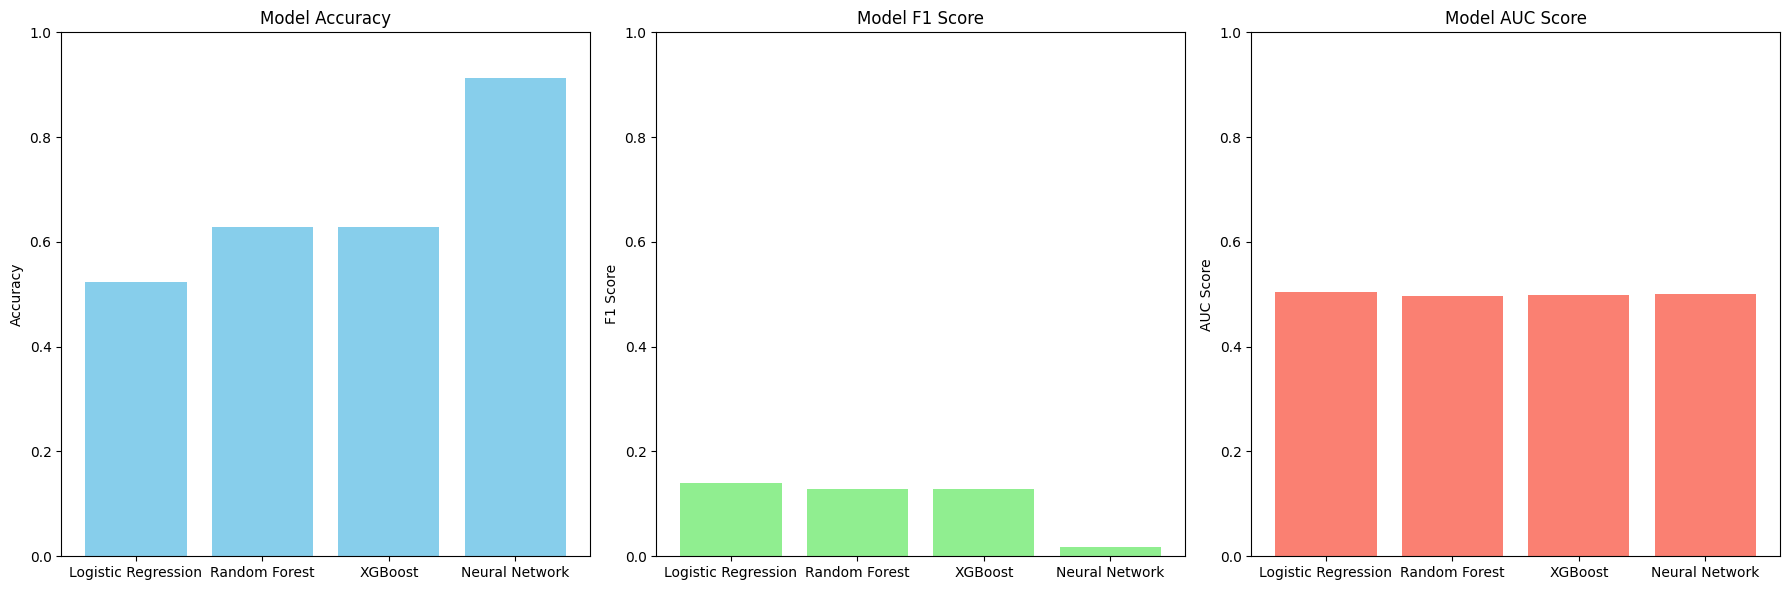

In [21]:
import matplotlib.pyplot as plt

# Metrics
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']
accuracies = [lr_accuracy, rf_accuracy, xgb_accuracy, nn_accuracy]
f1_scores = [lr_f1, rf_f1, xgb_f1, nn_f1]
auc_scores = [lr_auc, rf_auc, xgb_auc, nn_auc]

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy
ax[0].bar(models, accuracies, color='skyblue')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)

# F1 Score
ax[1].bar(models, f1_scores, color='lightgreen')
ax[1].set_title('Model F1 Score')
ax[1].set_ylabel('F1 Score')
ax[1].set_ylim(0, 1)

# AUC Score
ax[2].bar(models, auc_scores, color='salmon')
ax[2].set_title('Model AUC Score')
ax[2].set_ylabel('AUC Score')
ax[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()